## Data preparation and sanitization

,prop,other_resp,other_prop,time_spent_risk,cells,selfish,time_spent_prop,count_effort,Honesty_Humility,Extraversion,Agreeableness,min_offer
0,50,50,50,43000,26,60,31000,20,4.2,3.0,2.8,50
1,50,20,20,12000,7,20,38000,20,1.9,4.4,2.9,50
2,120,50,80,88000,50,20,69000,12,3.3,3.8,3.4,80
3,50,50,50,24000,50,60,26000,14,3.6,3.8,2.6,50
4,100,50,50,137000,24,60,43000,4,3.6,2.5,2.7,100


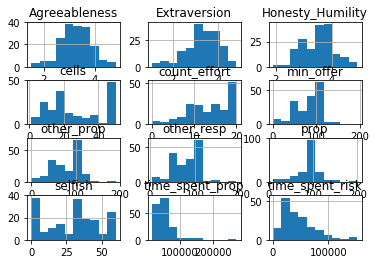

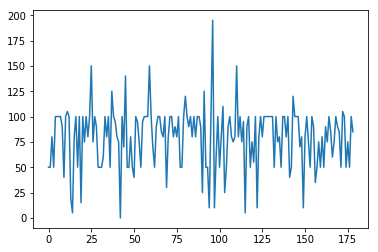

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sb

# Read and sanitize the data
df = pd.read_excel("./UG_HH_NEW_continuous_no200.xls")
df = df.dropna()

#print(df[50:])

# Show head and histograms
display(df.head())
df.hist()

# Plot sample figure for min_offers
plt.figure()

x = range(0, len(df['prop']))
x1 = df['min_offer']

plt.plot(x, x1)

## Individual plots

/home/franck/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


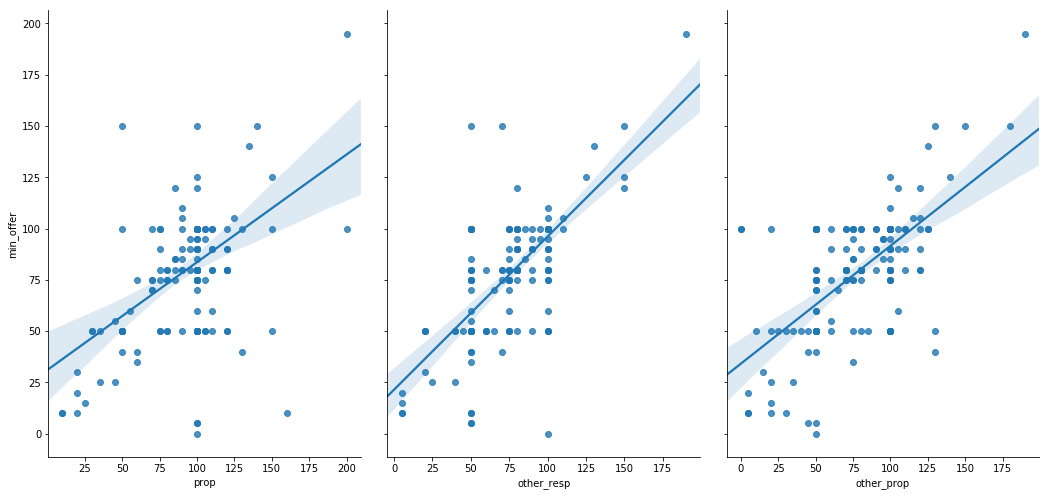

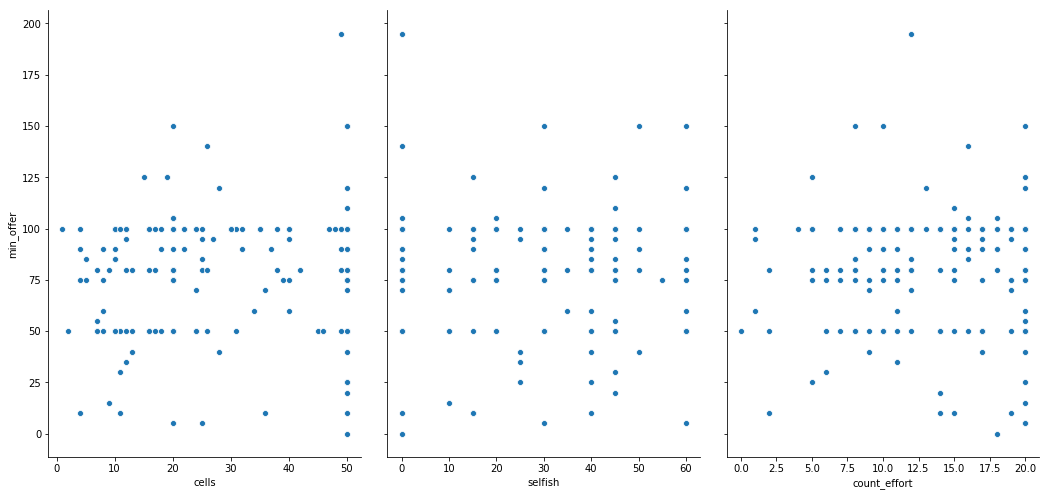

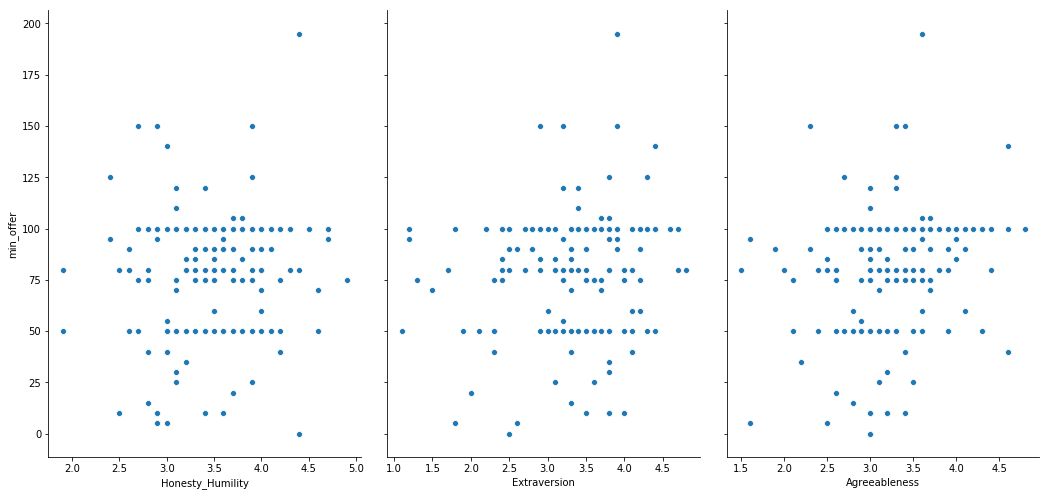

In [2]:
sb.pairplot(df, x_vars=('prop','other_resp','other_prop'), y_vars='min_offer', height=7, aspect=0.7, kind='reg')
sb.pairplot(df, x_vars=('cells', 'selfish','count_effort'), y_vars='min_offer', height=7, aspect=0.7)
sb.pairplot(df, x_vars=('Honesty_Humility', 'Extraversion','Agreeableness'), y_vars='min_offer', height=7, aspect=0.7)

## Mean and standard deviation

In [3]:
min_offers = df.iloc[:, -1:].values
mean = np.mean(min_offers)
std = np.std(min_offers)

print("Mean:", mean)
print("Sigma:", std)

Mean: 79.80446927374301
Sigma: 29.570307886750392


## Linear regression (continuous dataset)

In [4]:
def gain(predicted, min_offer):
    return 0 if predicted < min_offer else predicted

def loss(predicted, min_offer):
    return min_offer if predicted < min_offer else predicted - min_offer


Intercept: [12.14795034]
Coef: [[-2.00585445e-02  4.83360086e-01  3.84727117e-01  9.83711395e-05
   1.26315032e-01 -3.59930595e-02 -1.64681964e-04 -3.20690818e-01
  -3.59917342e+00  2.18793249e+00  2.95923847e+00]]
R2: 0.47718086219801525
    y_test      y_pred
0      100  104.758896
1      100  102.059325
2      100   52.520034
3      100   64.208075
4       80   55.966847
5       90   81.786097
6      100  102.444911
7      120   91.481684
8       50   54.815745
9       80   72.518458
10     100   83.013446
11      75   65.050118
12      80  103.190294
13     100   77.085411
14     100   96.391590
15      50   69.377777
16     100   54.632294
17      10   16.485387
18     125  112.715923
19      10   53.001047
20      75   82.389194
21     100   91.688370
22      90   87.985569
23     100   60.033943
24      90   72.608936
25     100  103.490745
26     100  100.027135
27      85   58.016824
28     100   95.801134
29      70   64.637533
30      70   51.435992
31      75   52.158158
32

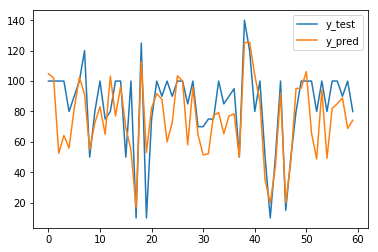

In [5]:
from sklearn.linear_model import LinearRegression

#df = df.drop('count_effort', 1)
#df = df.drop('selfish', 1)
#df = df.drop('cells', 1)

#print(df)

# Split into inputs and oututs
x = df.iloc[:, :-1].values

y = df.iloc[:, -1:].values
#print(x)
#print(y)

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 1/3, random_state = 0)
#print(xTrain)
#print(yTrain)

regressor = LinearRegression(copy_X=True).fit(xTrain, yTrain)

print("Intercept:", regressor.intercept_)
print("Coef:", regressor.coef_)

yPredict = regressor.predict(xTest)
print("R2:", r2_score(yTest, yPredict))

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPredict)})
print(out_data)

out_data.plot()

## Determine significant features

In [6]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression
from sklearn.feature_selection import RFE

NUM_FEATURES = 4

test = SelectKBest(score_func=f_regression, k=NUM_FEATURES)
fit = test.fit(xTrain, yTrain)
print(fit.scores_)

# Retrieve the feature index and the corresponding names
max_indices = fit.scores_.argsort()[-NUM_FEATURES:][::-1]
print(max_indices)
max_features = [df.columns.values[index] for index in max_indices]
print(max_features)

[2.57690035e+01 9.44783670e+01 7.90854633e+01 8.88924604e+00
 3.65064521e-01 1.74086982e+00 2.10919178e-03 3.34212911e-01
 1.92695223e+00 2.61298426e+00 4.09875329e+00]
[1 2 0 3]
['other_resp', 'other_prop', 'prop', 'time_spent_risk']


/home/franck/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [7]:
rfe = RFE(regressor, NUM_FEATURES)
fit = rfe.fit(xTrain, yTrain)
print("Features", fit.n_features_)
print("Selected features", fit.support_)
print("Feature ranking", fit.ranking_)

max_indices = [i for i, b in enumerate(fit.support_) if b]
print(max_indices)

max_features = [df.columns.values[index] for index in max_indices]
print(max_features)

/home/franck/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Features 4
Selected features [False  True False False False False False False  True  True  True]
Feature ranking [5 1 2 8 3 6 7 4 1 1 1]
[1, 8, 9, 10]
['other_resp', 'Honesty_Humility', 'Extraversion', 'Agreeableness']


## Bayesian ridge model (continuous)

   other_resp  Honesty_Humility  Extraversion  Agreeableness
0          50               4.2           3.0            2.8
1          20               1.9           4.4            2.9
2          50               3.3           3.8            3.4
3          50               3.6           3.8            2.6
4          50               3.6           2.5            2.7
[75.          3.20000005  3.29999995]
[50]
R2: 0.5852894222069152
    y_test      y_pred
0      100   93.971384
1      100   93.587122
2      100   93.663049
3      100   56.598902
4       80   56.263119
5       90   86.175266
6      100   93.898278
7      120   78.656957
8       50   56.403693
9       80   74.708362
10     100   93.584043
11      75   70.607139
12      80   78.919375
13     100   93.455525
14     100   93.608154
15      50   56.495270
16     100   56.119468
17      10   23.019567
18     125  112.365069
19      10   56.556321
20      75   78.818821
21     100   93.306233
22      90   78.516383
23     100   56.

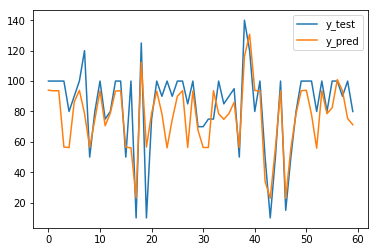

In [8]:
from sklearn.linear_model import BayesianRidge

# Use features from above
new_df = df[max_features]
print(new_df.head())

# Split dataset
x = new_df.iloc[:, :-1].values
y = df.iloc[:, -1:].values
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 1/3, random_state = 0)

print(xTrain[0])
print(yTrain[0])

regressor = BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
      lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
      normalize=False, tol=0.001, verbose=False).fit(xTrain, np.ravel(yTrain))
yPredict = regressor.predict(xTest)
print("R2:", r2_score(yTest, yPredict))

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPredict)})
print(out_data)

out_data.plot()

## Polynomial linear regression (continuous)

R2: 0.47817043742328835
    y_test      y_pred
0      100   91.949754
1      100   97.345615
2      100   93.322906
3      100   63.429392
4       80   57.489908
5       90   85.986321
6      100   92.568402
7      120   78.703270
8       50   58.949817
9       80   69.368101
10     100   96.836019
11      75   47.385948
12      80   78.974160
13     100   91.056433
14     100   93.096990
15      50   59.994686
16     100   54.534865
17      10   34.627862
18     125  123.022604
19      10   60.383769
20      75   79.810656
21     100   93.624260
22      90   75.037887
23     100   51.261433
24      90   69.901161
25     100   89.947309
26     100   93.524189
27      85   57.732130
28     100   93.336760
29      70   68.580184
30      70   59.123308
31      75   57.459862
32      75   93.197571
33     100   77.212544
34      85   72.406442
35      90   77.998503
36      95   83.719212
37      50   56.600462
38     140  120.005955
39     120  144.664866
40      80   93.765701
41     100

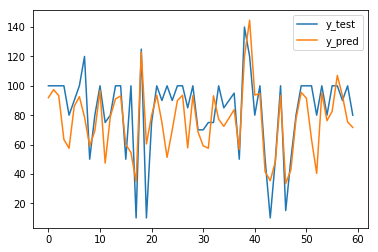

In [9]:
from sklearn.preprocessing import PolynomialFeatures

polynomial_features= PolynomialFeatures(degree=2)
x_poly = polynomial_features.fit_transform(xTrain)

regressor = LinearRegression(copy_X=True).fit(x_poly, yTrain)
yPredict = regressor.predict(polynomial_features.fit_transform(xTest))
print("R2:", r2_score(yTest, yPredict))

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPredict)})
print(out_data)

out_data.plot()

## Applying logistic regression to the categorial dataset

Intercept: [  9.03688639   2.91749603  -0.52790853  -1.87066612  -4.6228321
  -0.39048541   2.95246763   7.09438772  -1.93451605  -4.61053729
   5.86425722   3.90531597   0.03575936   4.91575276  -5.71435264
  -5.82826318  -9.19683504   4.26340409   1.93153287  -3.63698933
   2.43884724 -10.68742592   3.66470435]
Coef: [[-1.79537635e-01 -1.55717053e-01 -1.22412886e-01 ... -2.27927246e-02
   7.93655424e-02 -3.27296684e-02]
 [ 1.26214834e-01  8.60228176e-02  3.65360383e-01 ... -2.07270790e-02
   4.94189740e-01 -1.78983052e-01]
 [-5.47248996e-02  2.23418833e-02 -6.40430016e-02 ... -4.33821748e-02
   6.37509831e-02 -3.01186890e-02]
 ...
 [-8.11244493e-02  4.54412207e-02  1.02063479e-01 ... -1.05591550e-04
   7.89770773e-02 -2.14206650e-02]
 [ 3.70538803e-02 -2.36794414e-01  8.60678210e-03 ...  2.71197837e-02
  -3.27296171e-02 -3.40810040e-02]
 [-5.77210599e-02 -8.33704105e-02 -3.09184648e-01 ...  2.04927078e-01
   4.10441054e-02  3.57281405e-01]]
R2: -0.8835942918701944
    y_test  y_pred


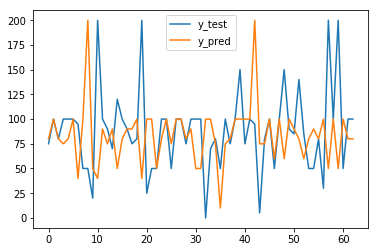

In [13]:
from sklearn.linear_model import LogisticRegression

df = pd.read_excel("UG_HH_NEW_categorical.xls")
df = df.dropna()

x = df.iloc[:, :-1].values
y = df.iloc[:, -1:].values
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 1/3, random_state = 0)

regressor = LogisticRegression(solver='newton-cg', multi_class='multinomial').fit(xTrain, np.ravel(yTrain))

print("Intercept:", regressor.intercept_)
print("Coef:", regressor.coef_)

yPredict = regressor.predict(xTest)
print("R2:", r2_score(yTest, yPredict))

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPredict)})
print(out_data)
out_data.plot()

## Testing clustering

[[2. 4. 3. ... 0. 0. 1.]
 [5. 5. 5. ... 0. 1. 0.]
 [3. 4. 4. ... 0. 1. 0.]
 ...
 [4. 4. 4. ... 0. 0. 0.]
 [3. 3. 1. ... 0. 1. 0.]
 [3. 2. 4. ... 1. 0. 0.]]
labels:  125 [1 7 5 5 2 0 0 6 5 1 1 0 2 2 2 5 2 2 1 0 4 6 0 1 0 7 0 2 0 7 0 6 0 0 1 0 2
 5 0 1 7 7 0 7 1 6 7 6 5 1 1 4 4 1 6 1 0 2 2 1 1 7 7 2 2 0 7 7 7 7 6 2 6 6
 7 0 0 2 2 4 3 2 3 3 6 2 3 4 2 7 7 0 2 1 4 7 7 2 0 0 0 2 6 0 0 0 0 2 0 6 1
 2 1 6 4 4 2 2 5 6 7 7 1 6 0]


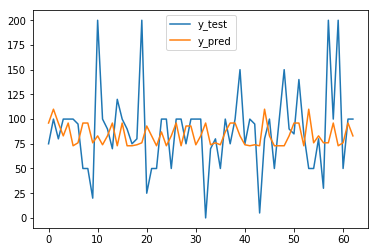

In [44]:
from sklearn.cluster import KMeans
#from functools import reduce
x = df.iloc[:1]
#display(x)

print(xTrain)
n_clusters = 8

kmeans = KMeans(random_state=0, n_clusters=8).fit(xTrain)
print("labels: ", len(kmeans.labels_), kmeans.labels_)
#xTrainClasses = kmeans.predict(xTrain)

#reduce cluster's target value
#reduce using mean
buckets = [[] for _ in range(n_clusters)]
for idx, y in enumerate(kmeans.labels_):
    buckets[y].append(yTrain[idx][0])

    
yTrainCluster = np.array([0] * n_clusters)
for idx in range(len(yTrainCluster)):
    if buckets[idx]:
        yTrainCluster[idx] = np.mean(buckets[idx])

yPredict = yTrainCluster[kmeans.predict(xTest)]
yPredict = np.array(yPredict)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPredict)})
out_data.plot()